In [114]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import xgboost as xgb
from sklearn.svm import SVC
%matplotlib inline

**Data loading**

In [115]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_disease_data = heart_disease.data.features 
target = heart_disease.data.targets 
print(heart_disease_data, target)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3.0   3.0  
2        2  2.0

In [116]:
def map_target_values(value):
    if value > 0:
        return 1
    else:
        return 0

# Apply the function to the target column
target = target['num'].map(map_target_values)
print(target)

0      0
1      1
2      1
3      0
4      0
      ..
298    1
299    1
300    1
301    1
302    0
Name: num, Length: 303, dtype: int64


In [117]:
target.value_counts()

num
0    164
1    139
Name: count, dtype: int64

In [118]:
# Load your data
#heart_disease_data = pd.read_csv('heart.csv')

In [119]:
heart_disease_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB


In [120]:
heart_disease_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


**Data formatting and cleaning**

*Renaming the columns with more meaningful names*

In [121]:
# Define a dictionary for renaming the columns
renaming_dict = {
    'age': 'age',
    'sex': 'gender',
    'cp': 'chest_pain_type',
    'trestbps': 'resting_blood_pressure',
    'chol': 'serum_cholesterol_mg_per_dl',
    'fbs': 'fasting_blood_sugar_gt_120_mg_per_dl',
    'restecg': 'resting_ecg_results',
    'thalach': 'maximum_heart_rate_achieved',
    'exang': 'exercise_induced_angina',
    'oldpeak': 'st_depression_induced_by_exercise_relative_to_rest',
    'slope': 'slope_of_peak_exercise_st_segment',
    'ca': 'number_of_major_vessels_colored_by_flourosopy',
    'thal': 'thalassemia',
}

# Code to rename the columns
heart_disease_data_renamed = heart_disease_data.rename(columns=renaming_dict)

*Checking for missing values*

In [122]:
# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Impute the missing values using K-Nearest Neighbors
heart_disease_data_imputed = pd.DataFrame(imputer.fit_transform(heart_disease_data_renamed),
                                          columns=heart_disease_data_renamed.columns)

# Check if there are any missing values left
missing_values_after_imputation = heart_disease_data_imputed.isnull().sum()

heart_disease_data_imputed.head(), missing_values_after_imputation


(    age  gender  chest_pain_type  resting_blood_pressure  \
 0  63.0     1.0              1.0                   145.0   
 1  67.0     1.0              4.0                   160.0   
 2  67.0     1.0              4.0                   120.0   
 3  37.0     1.0              3.0                   130.0   
 4  41.0     0.0              2.0                   130.0   
 
    serum_cholesterol_mg_per_dl  fasting_blood_sugar_gt_120_mg_per_dl  \
 0                        233.0                                   1.0   
 1                        286.0                                   0.0   
 2                        229.0                                   0.0   
 3                        250.0                                   0.0   
 4                        204.0                                   0.0   
 
    resting_ecg_results  maximum_heart_rate_achieved  exercise_induced_angina  \
 0                  2.0                        150.0                      0.0   
 1                  2.0       

## Preprocessing

In [123]:
# Identify categorical and numerical columns
categorical_cols = heart_disease_data_imputed.select_dtypes(include=['object', 'category']).columns
numerical_cols = heart_disease_data_imputed.select_dtypes(include=['int64', 'float64']).columns

# Create a transformer for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Apply transformations to the dataset
heart_disease_data_preprocessed = preprocessor.fit_transform(heart_disease_data_imputed)

## Modeling

In [124]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(heart_disease_data_preprocessed, target, test_size=0.3, random_state=20)

In [125]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((212, 13), (91, 13), (212,), (91,))

## Random Forest

For the Random Forest model:
Accuracy on Training data:  94.33962264150944
Accuracy on Test data:  84.61538461538461


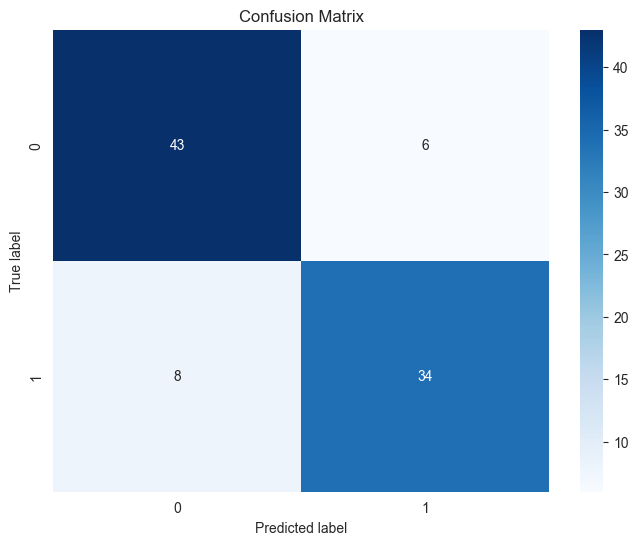

In [126]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    # Add other parameters here
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Accuracy on training data
print("For the Random Forest model:")
X_train_prediction_random_forest = best_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_random_forest,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)

# Accuracy on test data
y_pred_random_forest = best_model.predict(X_test)
accuracy = accuracy_score(y_pred_random_forest, y_test)
print(f"Accuracy on Test data: ",accuracy*100)

#Confussion matrix
RF_conf_matrix = confusion_matrix(y_test, y_pred_random_forest)
plt.figure(figsize=(8, 6))
sns.heatmap(RF_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Logistic Regression

Accuracy on Training data:  83.9622641509434
Accuracy on Test data:  76.92307692307693


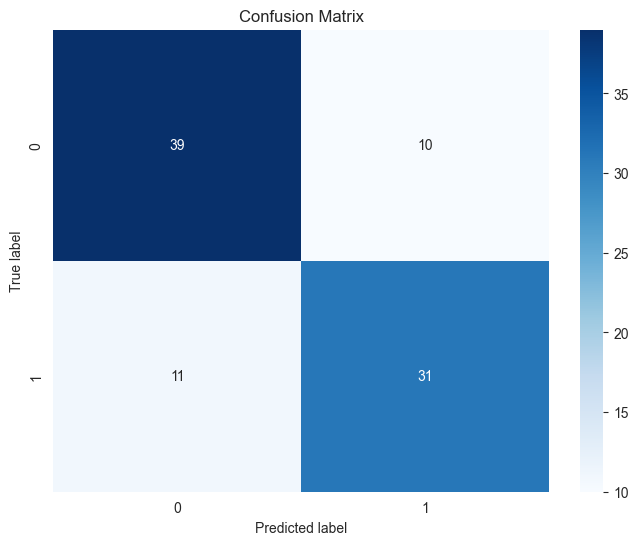

In [127]:
# Initialize the classifier
lr_model = LogisticRegression(solver="liblinear",random_state=2 )

# training the model with training data
lr_model.fit(X_train, y_train)
# Accuracy on training data
X_train_prediction_LR = lr_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_LR,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction_LR = lr_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction_LR, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_lr*100)

#Confussion matrix
LR_conf_matrix = confusion_matrix(y_test, X_test_prediction_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(LR_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## XGBoost

C:\Users\alexs\PycharmProjects\PfDa_Project_S7\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:20:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Accuracy on Training data:  100.0
Accuracy on Test data:  78.02197802197803


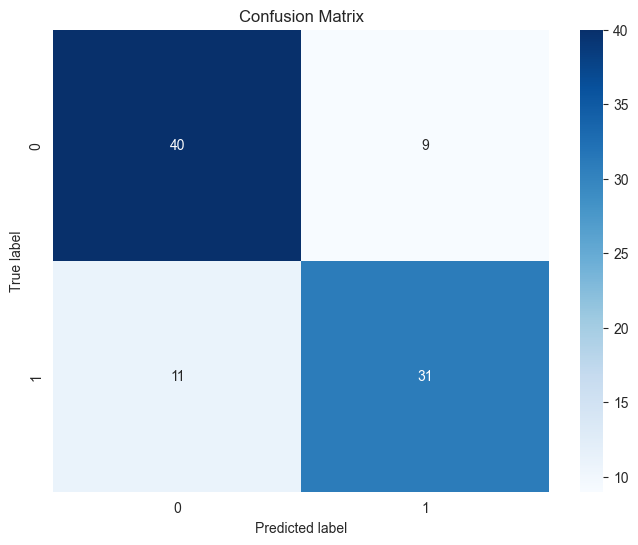

In [128]:
# Initialize the classifier
xgb_model = xgb.XGBClassifier(objective="reg:linear", random_state=42)

# training the model with training data
xgb_model.fit(X_train, y_train)
# Accuracy on training data
X_train_prediction_XGB = xgb_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_XGB,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction_XGB = xgb_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction_XGB, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_lr*100)

#Confussion matrix
XGB_conf_matrix = confusion_matrix(y_test, X_test_prediction_XGB)
plt.figure(figsize=(8, 6))
sns.heatmap(XGB_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [129]:
# TODO: Add a neural network classifier (maybe using tensoflow)

## Support Vector Classifier

Accuracy on Training data:  91.0377358490566
Accuracy on Test data:  80.21978021978022


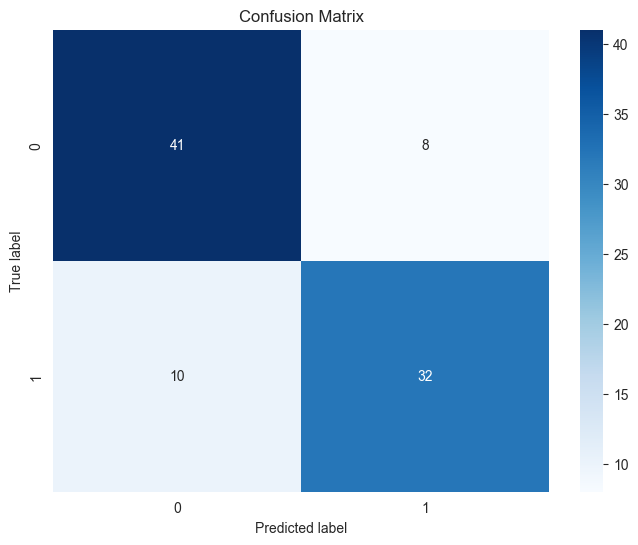

In [130]:
# Initialize the classifier
svc_model = SVC(random_state=20 )

# training the model with training data
svc_model.fit(X_train, y_train)
# Accuracy on training data
X_train_prediction_SVC = svc_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_SVC,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction_SVC = svc_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction_SVC, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_lr*100)

#Confussion matrix
SVC_conf_matrix = confusion_matrix(y_test, X_test_prediction_SVC)
plt.figure(figsize=(8, 6))
sns.heatmap(SVC_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Neural Network CLassifier

Epoch 1/10
6/6 [==============================] - 1s 35ms/step - loss: 0.6516 - accuracy: 0.6526 - val_loss: 0.5814 - val_accuracy: 0.7273
Epoch 2/10
6/6 [==============================] - 0s 8ms/step - loss: 0.5578 - accuracy: 0.7842 - val_loss: 0.5305 - val_accuracy: 0.7273
Epoch 3/10
6/6 [==============================] - 0s 8ms/step - loss: 0.4854 - accuracy: 0.7947 - val_loss: 0.4929 - val_accuracy: 0.7273
Epoch 4/10
6/6 [==============================] - 0s 8ms/step - loss: 0.4346 - accuracy: 0.8211 - val_loss: 0.4634 - val_accuracy: 0.7273
Epoch 5/10
6/6 [==============================] - 0s 8ms/step - loss: 0.3964 - accuracy: 0.8263 - val_loss: 0.4447 - val_accuracy: 0.7273
Epoch 6/10
6/6 [==============================] - 0s 8ms/step - loss: 0.3691 - accuracy: 0.8474 - val_loss: 0.4336 - val_accuracy: 0.7273
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 0.3459 - accuracy: 0.8526 - val_loss: 0.4260 - val_accuracy: 0.7273
Epoch 8/10
6/6 [=================

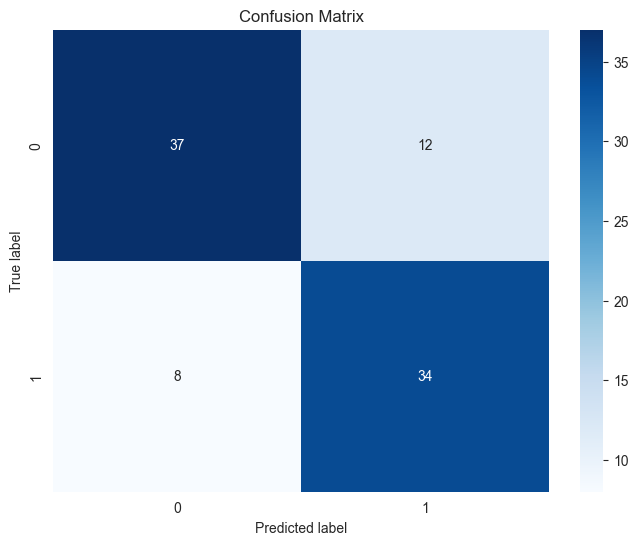

In [131]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 'sigmoid' for binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Predictions
y_pred_NNC = model.predict(X_test)
y_pred_NNC = np.round(y_pred_NNC).flatten()  # Convert probabilities to binary predictions

# Accuracy
accuracy = accuracy_score(y_test, y_pred_NNC)
print(f"Accuracy on Test data: ",accuracy*100)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_NNC)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()